In [1]:
import math
from functools import partial
import numpy as np
import pandas as pd
from scipy.optimize import (
    linprog,
    minimize,
    differential_evolution,
    NonlinearConstraint,
)
import matplotlib.pyplot as plt

import sys

sys.path.append("./../app")

import nordpool
import smhi

In [2]:
LONGITUDE = 12.1
LATITUDE = 57.6
AREA = "SE3"

In [3]:
# Constants
k1 = 1 / 450000
k2 = 1.5625 * k1
K = k1 + k2

In [4]:
# Nordpool prices
from datetime import date

prices = nordpool.fetch_nordpool_data(AREA)
prices = np.asarray(prices)
prices = prices[prices != 0]
prices

array([19.35, 18.73, 16.58, 14.49, 15.25, 15.62, 15.56, 16.01, 16.92,
       17.57, 18.2 , 18.9 , 20.98, 21.46, 20.96, 19.94, 18.24, 13.38,
       16.34, 17.19, 17.39, 18.94, 20.55, 19.54, 18.35, 18.81, 17.69,
       16.77])

In [5]:
temperatures = smhi.fetch_smhi_temperatures(LONGITUDE, LATITUDE)
temperatures = np.insert(
    temperatures, 0, temperatures[0]
)  # Use forecast for next hour as the current temperature (for testing only, this should be replaced with a proper outdoor sensor when run in production)

temperatures = np.asarray(temperatures[: len(prices)])
temperatures

array([12.6, 12.6, 13.2, 13.1, 12.8, 12.9, 12.8, 12.5, 11.1, 10.9, 10. ,
        9.5, 10.5, 12. , 11.9, 11.9, 12.5, 13.2, 12.2, 11. , 11.9, 11.8,
       11.4, 11.3, 11. , 10.8, 10.5, 10.4])

In [6]:
len(prices) == len(temperatures)

True

In [7]:
# Forecasted outdoor temperature
T_out = np.array(temperatures)

In [8]:
# Initial guess
def heating_curve(slope: float, T_out: float) -> float:
    return 20 + (-0.16 * slope) * (T_out - 20)


def inverse_heating_curve(slope: float, T_fr: float) -> float:
    return (T_fr - 20) / (-0.16 * slope) + 20


T_fr_0 = np.asarray(list(map(partial(heating_curve, 4.7), T_out)))
T_fr_0 = np.ones_like(T_out) * 19.5
T_fr_0

array([19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5,
       19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5, 19.5,
       19.5, 19.5, 19.5, 19.5, 19.5, 19.5])

In [9]:
def objective(x: np.ndarray):
    # return x.sum() / 19.5 # Minimize energy
    return (x * prices).sum() / (prices.sum())  # Minimize cost


def _analytical_solution(T_in_0: float, T_fr: float, T_out: float, t: float = 3600):
    T_w = (k2 * T_fr + k1 * T_out) / K
    delta = T_in_0 - T_w
    return T_w + delta * math.exp(-K * t)


def simulation(T_fr: np.ndarray):
    T_ins = []
    T_in = 19.5
    T_ins.append(T_in)

    for (Tfr, Tout) in zip(T_fr, T_out):
        T_in = _analytical_solution(T_in, Tfr, Tout)
        T_ins.append(T_in)

    return T_ins


def temperature_span_constraint(x: np.ndarray):
    T_ins = simulation(x)
    lower = np.array(T_ins) - 17
    upper = 21 - np.array(T_ins)
    return np.concatenate([lower, upper])


def final_temperature_constraint(x: np.ndarray):
    return simulation(x)[-1] - 19.0

In [10]:
res = minimize(
    objective,
    T_fr_0,
    method="SLSQP",
    constraints=[
        {
            "type": "ineq",
            "fun": temperature_span_constraint,
        },
        {"type": "eq", "fun": final_temperature_constraint},
    ],
    bounds=[(19, 55)] * len(prices),
    options={
        "maxiter": 500,
    },
)

In [11]:
res

     fun: 21.652296141663836
     jac: array([0.03872252, 0.03748178, 0.03317952, 0.02899694, 0.03051782,
       0.03125811, 0.03113818, 0.03203869, 0.03385973, 0.0351603 ,
       0.03642106, 0.03782201, 0.04198432, 0.04294491, 0.04194427,
       0.03990316, 0.03650117, 0.02677536, 0.03269935, 0.03439999,
       0.03480029, 0.03790188, 0.04112411, 0.03910279, 0.03672147,
       0.037642  , 0.03540039, 0.03355932])
 message: 'Optimization terminated successfully'
    nfev: 2378
     nit: 82
    njev: 82
  status: 0
 success: True
       x: array([19.        , 19.        , 19.        , 19.        , 19.        ,
       19.        , 19.        , 19.        , 19.        , 19.        ,
       19.        , 19.        , 19.        , 19.        , 19.        ,
       19.        , 19.        , 55.        , 19.        , 19.        ,
       19.        , 19.        , 19.        , 19.        , 19.        ,
       19.        , 32.56579451, 55.        ])

In [12]:
simulation(res.x)

[19.5,
 19.439175580407763,
 19.37958536757523,
 19.32595545232245,
 19.272621902210773,
 19.217994992110494,
 19.165268388971057,
 19.112819821592453,
 19.059059936771998,
 18.995304929629228,
 18.931259883192986,
 18.861387692507265,
 18.788974020914058,
 18.725948274583903,
 18.67607923901249,
 18.626430255431046,
 18.577788714445184,
 18.53488530821543,
 18.943814316131544,
 18.891108206077867,
 18.829969302732906,
 18.777197689158953,
 18.724705024666225,
 18.670110081772236,
 18.61583108568813,
 18.560277913946614,
 18.50426827698004,
 18.61486571183123,
 18.99999985217608]

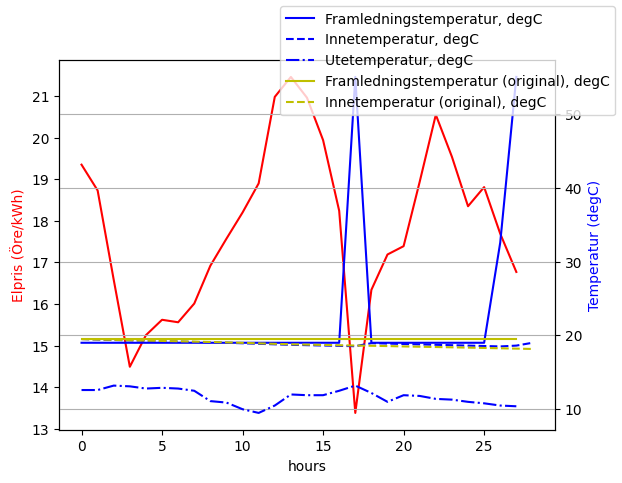

In [13]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices, "r")
ax2.plot(res.x, "b-", label="Framledningstemperatur, degC")
ax2.plot(simulation(res.x), "b--", label="Innetemperatur, degC")
ax2.plot(T_out, "b-.", label="Utetemperatur, degC")
ax2.plot(T_fr_0, "y", label="Framledningstemperatur (original), degC")
ax2.plot(simulation(T_fr_0), "y--", label="Innetemperatur (original), degC")

ax1.set_xlabel("hours")
ax1.set_ylabel("Elpris (Öre/kWh)", color="r")
ax2.set_ylabel("Temperatur (degC)", color="b")

fig.legend()
plt.grid()

In [14]:
print("Optimal framledningstemperatur just nu:", res.x[0], "degC")
print(
    "Styrsignal till VP (fejkad utetemperatur):",
    inverse_heating_curve(4.7, res.x[0]),
    "degC",
)
print("Besparing:", (1 - (res.x * prices).sum() / (T_fr_0 * prices).sum()) * 100, "%")

Optimal framledningstemperatur just nu: 19.000000000000014 degC
Styrsignal till VP (fejkad utetemperatur): 21.329787234042534 degC
Besparing: -11.037416111096586 %
